In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from urllib.request import urlopen
from bs4 import BeautifulSoup
import pandas as pd
import re
import pymc3 as pm
import theano.tensor as tt
import matplotlib.pyplot as plt
from IPython.display import Image, HTML
from IPython.core.pylabtools import figsize
import numpy as np
from io import StringIO
import math
import seaborn as sns
from html.parser import HTMLParser

In [2]:
def get_season_game_scrap(season, year) :
    
    scores_all_months = []
   
    if season == 'RS':
        months_list = ['october', 'november', 'december', 'january', 'february', 'march', 'april']
    elif season == 'PO':
         months_list = ['april', 'may', 'june']

    
    for i in months_list:
        url = "https://www.basketball-reference.com/leagues/NBA_"+ year + "_games-" + i + ".html"
        
        # this is the html from the given url
        html = urlopen(url)
        soup = BeautifulSoup(html , "lxml")
    
        column_headers = []
        for th in soup.findAll('tr', limit=2)[0].findAll('th'):
            column_headers.append(th.getText())
    
        data_rows = soup.findAll('tr')[1:]

        match_data_month = []  # create an empty list to hold all the data

        for i in range(len(data_rows)):  # for each table row
            match_row = []  # create an empty list for each pick/player

            # for each table data element from each table row
            for td in data_rows[i].findAll(re.compile('t[dh]')):        
                # get the text content and append to the player_row 
                match_row.append(td.getText())        

            # then append each pick/player to the player_data matrix
            match_data_month.append(match_row)

        df = pd.DataFrame(match_data_month, columns=column_headers)

        try:
            playoffs_start = df.loc[df['Date'] == 'Playoffs'].index[0]
        except :
            df = df
        else:
            if season == 'RS':
                df = df[df.index < playoffs_start]
            elif  season == 'PO':
                df = df[df.index > playoffs_start]
        
        scores_all_months.append(df)
    
    scores_regular_season = pd.concat(scores_all_months)
    scores_regular_season = scores_regular_season.iloc[:, 2:6]
    scores_regular_season.columns=['away_long','away_points', 'home_long','home_points']
    
    return(scores_regular_season)

In [3]:
year = '2017'
reg_season = get_season_game_scrap('RS', year)
play_offs = get_season_game_scrap('PO', year)

In [4]:
def get_season_ranking(url):
    
    html = urlopen(url)
    soup = BeautifulSoup(html , "lxml")

    tables_list = soup.findAll('table')

    df_all = []
    for table in tables_list[:4]:
        rows = table.findAll('tr')

        column_headers = []
        for th in rows[0].findAll('th'):
            column_headers.append(th.getText())

        data_rows = rows[1:]

        match_data_month = []
        for i in range(len(data_rows)):  # for each table row
            match_row = []  # create an empty list for each pick/player

            #for each table data element from each table row
            for td in data_rows[i].findAll(re.compile('t[dh]'):        
                # get the text content and append to the player_row 
                match_row.append(td.getText())        

            # then append each pick/player to the player_data matrix
            match_data_month.append(match_row)

        #print(match_data_month)
        df = pd.DataFrame(match_data_month, columns=column_headers)
        df_all.append(df)
    
    return(df_all)

In [5]:
def get_expanded_standings(year):
    """
    Parsing from ESPN website
    """
    url = 'http://proxy.espn.com/nba/standings?year=' + year + '&group=1'
    html = urlopen(url)
    soup = BeautifulSoup(html, 'lxml')
    tables_list = soup.findAll('table')[0]


    rows = tables_list.findAll('tr')
    column_headers = []
    for th in rows[1].findAll('td'):
        column_headers.append(th.getText())

    data_rows = rows[2:]

    match_data_month = []
    for i in range(len(data_rows)):  # for each table row
        match_row = []  # create an empty list for each pick/player

        #for each table data element from each table row
        for td in data_rows[i].findAll(re.compile('t[dh]')):        
            # get the text content and append to the player_row 
            match_row.append(td.getText())

        # then append each pick/player to the player_data matrix
        match_data_month.append(match_row)


    df = pd.DataFrame(match_data_month, columns=column_headers)
    return(df)

In [6]:
def get_season_ranking(year):
    
    url = 'https://www.basketball-reference.com/leagues/NBA_'+ year + '_standings.html'
    html = urlopen(url)
    soup = BeautifulSoup(html , "lxml")


    tables_list = soup.findAll('table')

    df_all = []
    for table in tables_list[:4]:
        rows = table.findAll('tr')

        column_headers = []
        for th in rows[0].findAll('th'):
            column_headers.append(th.getText())

        data_rows = rows[1:]

        match_data_month = []
        for i in range(len(data_rows)):  # for each table row
            match_row = []  # create an empty list for each pick/player

            #for each table data element from each table row
            for td in data_rows[i].findAll(re.compile('t[hd]')):        
                # get the text content and append to the player_row 
                match_row.append(td.getText())        

            # then append each pick/player to the player_data matrix
            match_data_month.append(match_row)

        #print(match_data_month)
        df = pd.DataFrame(match_data_month, columns=column_headers)
        df_all.append(df)
    
    return(df_all)

In [221]:
east_standing = get_season_ranking(year)[0]
west_standing = get_season_ranking(year)[1]
expanded_standing = get_expanded_standings(year)
expanded_standing['espn_name'] = expanded_standing.apply(lambda x: re.search(r"\b[A-Z]{1}[A-Z a-z]*", x['NBA']).group(0), axis=1)

In [222]:
df_teams = pd.DataFrame(columns=['long_name','espn_name', 'short_name', 'i_number','conference', 'division'])
df_teams.loc[1] = pd.Series({'long_name': 'Atlanta Hawks', 'espn_name': 'Atlanta', 'short_name': 'ATL', 'i_number': 0, 'conference': 'East', 'division': 'Southeast'})
df_teams.loc[2] = pd.Series({'long_name': 'Boston Celtics', 'espn_name': 'Boston', 'short_name': 'BOS', 'i_number': 1, 'conference': 'East', 'division': 'Atlantic'})
df_teams.loc[3] = pd.Series({'long_name': 'Brooklyn Nets', 'espn_name': 'Brooklyn', 'short_name': 'BKN', 'i_number': 2, 'conference': 'East', 'division': 'Atlantic'})
df_teams.loc[4] = pd.Series({'long_name': 'Charlotte Hornets', 'espn_name': 'Charlotte', 'short_name': 'CHA', 'i_number': 3, 'conference': 'East', 'division': 'Southeast'})
df_teams.loc[5] = pd.Series({'long_name': 'Chicago Bulls', 'espn_name': 'Chicago', 'short_name': 'CHI', 'i_number': 4, 'conference': 'East', 'division': 'Central'})
df_teams.loc[6] = pd.Series({'long_name': 'Cleveland Cavaliers', 'espn_name': 'Cleveland', 'short_name': 'CLE', 'i_number': 5, 'conference': 'East', 'division': 'Central'})
df_teams.loc[7] = pd.Series({'long_name': 'Dallas Mavericks', 'espn_name': "Dallas", 'short_name': 'DAL', 'i_number': 6, 'conference': 'West', 'division': 'Southwest'})
df_teams.loc[8] = pd.Series({'long_name': 'Denver Nuggets', 'espn_name': "Denver", 'short_name': 'DEN', 'i_number': 7, 'conference': 'West', 'division': 'Northwest'})
df_teams.loc[9] = pd.Series({'long_name': 'Detroit Pistons', 'espn_name': "Detroit", 'short_name': 'DET', 'i_number': 8, 'conference': 'East', 'division': 'Central'})
df_teams.loc[10] = pd.Series({'long_name': 'Golden State Warriors', 'espn_name': "Golden State", 'short_name': 'GSW', 'i_number': 9, 'conference': 'West', 'division': 'Pacific'})
df_teams.loc[11] = pd.Series({'long_name': 'Houston Rockets', 'espn_name': 'Houston', 'short_name': 'HOU', 'i_number': 10, 'conference': 'West', 'division': 'Southwest'})
df_teams.loc[12] = pd.Series({'long_name': 'Indiana Pacers', 'espn_name': "Indiana", 'short_name': 'IND', 'i_number': 11, 'conference': 'East', 'division': 'Central'})
df_teams.loc[13] = pd.Series({'long_name': 'Los Angeles Clippers', 'espn_name': "LA", 'short_name': 'LAC', 'i_number': 12, 'conference': 'West', 'division': 'Pacific'})
df_teams.loc[14] = pd.Series({'long_name': 'Los Angeles Lakers', 'espn_name': "LA Lakers", 'short_name': 'LAL', 'i_number': 13, 'conference': 'West', 'division': 'Pacific'})
df_teams.loc[15] = pd.Series({'long_name': 'Memphis Grizzlies', 'espn_name': "Memphis", 'short_name': 'MEM', 'i_number': 14, 'conference': 'West', 'division': 'Southwest'})
df_teams.loc[16] = pd.Series({'long_name': 'Miami Heat', 'espn_name': 'Miami', 'short_name': 'MIA', 'i_number': 15, 'conference': 'East', 'division': 'Southeast'})
df_teams.loc[17] = pd.Series({'long_name': 'Milwaukee Bucks', 'espn_name': "Milwaukee", 'short_name': 'MIL', 'i_number': 16, 'conference': 'East', 'division': 'Central'})
df_teams.loc[18] = pd.Series({'long_name': 'Minnesota Timberwolves', 'espn_name': "Minnesota", 'short_name': 'MIN', 'i_number': 17, 'conference': 'West', 'division': 'Northwest'})
df_teams.loc[19] = pd.Series({'long_name': 'New Orleans Pelicans', 'espn_name': "New Orleans", 'short_name': 'NOP', 'i_number': 18, 'conference': 'West', 'division': 'Southwest'})
df_teams.loc[20] = pd.Series({'long_name': 'New York Knicks', 'espn_name': "New York", 'short_name': 'NYK', 'i_number': 19, 'conference': 'East', 'division': 'Atlantic'})
df_teams.loc[21] = pd.Series({'long_name': 'Oklahoma City Thunder', 'espn_name': 'Oklahoma City', 'short_name': 'OKC', 'i_number': 20, 'conference': 'West', 'division': 'Northwest'})
df_teams.loc[22] = pd.Series({'long_name': 'Orlando Magic', 'espn_name': "Orlando", 'short_name': 'ORL', 'i_number': 21, 'conference': 'East', 'division': 'Southeast'})
df_teams.loc[23] = pd.Series({'long_name': 'Philadelphia 76ers', 'espn_name': "Philadelphia", 'short_name': 'PHI', 'i_number': 22, 'conference': 'East', 'division': 'Atlantic'})
df_teams.loc[24] = pd.Series({'long_name': 'Phoenix Suns', 'espn_name': "Phoenix", 'short_name': 'PHX', 'i_number': 23, 'conference': 'West', 'division': 'Pacific'})
df_teams.loc[25] = pd.Series({'long_name': 'Portland Trail Blazers', 'espn_name': "Portland", 'short_name': 'POR', 'i_number': 24, 'conference': 'West', 'division': 'Northwest'})
df_teams.loc[26] = pd.Series({'long_name': 'Sacramento Kings', 'espn_name': 'Sacramento', 'short_name': 'SAC', 'i_number': 25, 'conference': 'West', 'division': 'Pacific'})
df_teams.loc[27] = pd.Series({'long_name': 'San Antonio Spurs', 'espn_name': "San Antonio", 'short_name': 'SAS', 'i_number': 26, 'conference': 'West', 'division': 'Southwest'})
df_teams.loc[28] = pd.Series({'long_name': 'Toronto Raptors', 'espn_name': "Toronto", 'short_name': 'TOR', 'i_number': 27, 'conference': 'East', 'division': 'Atlantic'})
df_teams.loc[29] = pd.Series({'long_name': 'Utah Jazz', 'espn_name': "Utah", 'short_name': 'UTA', 'i_number': 28, 'conference': 'West', 'division': 'Northwest'})
df_teams.loc[30] = pd.Series({'long_name': 'Washington Wizards', 'espn_name': "Washington", 'short_name': 'WAS', 'i_number': 29, 'conference': 'East', 'division': 'Southeast'})

teams = df_teams[['long_name','short_name', 'i_number']]
labels =  df_teams[['short_name']].iloc[:, 0].tolist()

expanded_standing = pd.merge(expanded_standing, df_teams, on = 'espn_name', how = 'left')

In [9]:
class Teams:

    def __init__(self, name_short, name_long, conference, division):
        self.name_short = name_short
        self.name_long = name_long
        self.conference = conference
        self.division = division
        
        
ATL = Teams('ATL', 'Atlanta Hawks', 'East', 'Southeast')
BOS = Teams('BOS', 'Boston Celtics', 'East', 'Atlantic')
BKN = Teams('BKN', 'Brooklyn Nets', 'East', 'Atlantic')
CHA = Teams('CHA', 'Charlotte Hornets', 'East', 'Southeast')
CHI = Teams('CHI', 'Chicago Bulls', 'East', 'Central')
CLE = Teams('CLE', 'Cleveland Cavaliers', 'East', 'Southeast')
DAL = Teams('DAL', 'Dallas Mavericks', 'West', 'Southwest')
DEN = Teams('DEN', 'Denver Nuggets', 'West', 'Northwest')
DET = Teams('DET', 'Detroit Pistons', 'East', 'Central')
GSW = Teams('GSW', 'Golden State Warriors', 'West', 'Pacific')
HOU = Teams('HOU', 'Houston Rockets', 'West', 'Southwest')
IND = Teams('IND', 'Indiana Pacers', 'East', 'Central')
LAC = Teams('LAC', 'Los Angeles Clippers', 'West', 'Pacific')
LAL = Teams('LAL', 'Los Angeles Lakers', 'West', 'Pacific')
MEM = Teams('MEM', 'Memphis Grizzlies', 'West', 'Southwest')
MIA = Teams('MIA', 'Miami Heat', 'East', 'Southeast')
MIL = Teams('MIL', 'Milwaukee Bucks', 'East', 'Central')
MIN = Teams('MIN', 'Minnesota Timberwolves', 'West', 'Northwest')
NOP = Teams('NOP', 'New Orleans Pelicans', 'West', 'Southwest')
NYK = Teams('NYK', 'New York Knicks', 'East', 'Atlantic')
OKC = Teams('OKC', 'Oklahoma City Thunder', 'West', 'Northwest')
ORL = Teams('ORL', 'Orlando Magic', 'East', 'Southeast')
PHI = Teams('PHI', 'Philadelphia 76ers', 'East', 'Atlantic')
PHX = Teams('PHX', 'Phoenix Suns', 'West', 'Pacific')
POR = Teams('POR', 'Portland Trail Blazers', 'West',  'Northwest')
SAC = Teams('SAC', 'Sacramento Kings', 'West', 'Pacific')
SAS = Teams('SAS', 'San Antonio Spurs', 'West', 'Southwest')
TOR = Teams('TOR', 'Toronto Raptors', 'East', 'Atlantic')
UTA = Teams('UTA', 'Utah Jazz', 'West', 'Northwest')
WAS = Teams('WAS', 'Washington Wizards', 'East', 'Southeast')

In [38]:
df = reg_season

df = pd.merge(df, teams, left_on='home_long', right_on = 'long_name', how='left')
df.rename(columns={"short_name": "home", "i_number" : "i_home"}, inplace=True)
df.drop('long_name', axis=1, inplace=True)

df = pd.merge(df, teams, left_on='away_long', right_on = 'long_name', how='left')
df.rename(columns={"short_name": "away", "i_number" : "i_away"}, inplace=True)
df.drop('long_name', axis=1, inplace=True)

observed_home_points = df.home_points.values
observed_away_points = df.away_points.values

home_team = df.i_home.values.tolist()
away_team = df.i_away.values.tolist()

df_reg_season = df 
num_teams = len(df.home.unique())
num_games = len(df)

In [11]:
model = pm.Model()

with pm.Model() as model:
    # global model parameters
    home = pm.Flat('home')
    sd_att = pm.Gamma('sd_att', .1, .1)
    sd_def = pm.Gamma('sd_def', .1, .1)
    intercept = pm.Flat('intercept')

    # team-specific model parameters
    atts_star = pm.Normal('atts_star', mu=0, sd=sd_att, shape=num_teams)
    defs_star = pm.Normal('defs_star', mu=0, sd=sd_def, shape=num_teams)
    
    atts = pm.Deterministic('atts', atts_star - tt.mean(atts_star))
    defs = pm.Deterministic('defs', defs_star - tt.mean(defs_star))
    home_theta = tt.exp(intercept + home + atts[home_team] + defs[away_team])
    away_theta = tt.exp(intercept + atts[away_team] + defs[home_team])
    
    # likelihood of observed data
    home_points = pm.Poisson('home_points', mu=home_theta, observed=observed_home_points)
    away_points = pm.Poisson('away_points', mu=away_theta, observed=observed_away_points)

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 9,435.9:  19%|█▉        | 38111/200000 [00:27<01:53, 1425.57it/s]   
Convergence archived at 38200
Interrupted at 38,200 [19%]: Average Loss = 1.4493e+05
100%|██████████| 51000/51000 [07:14<00:00, 117.27it/s]


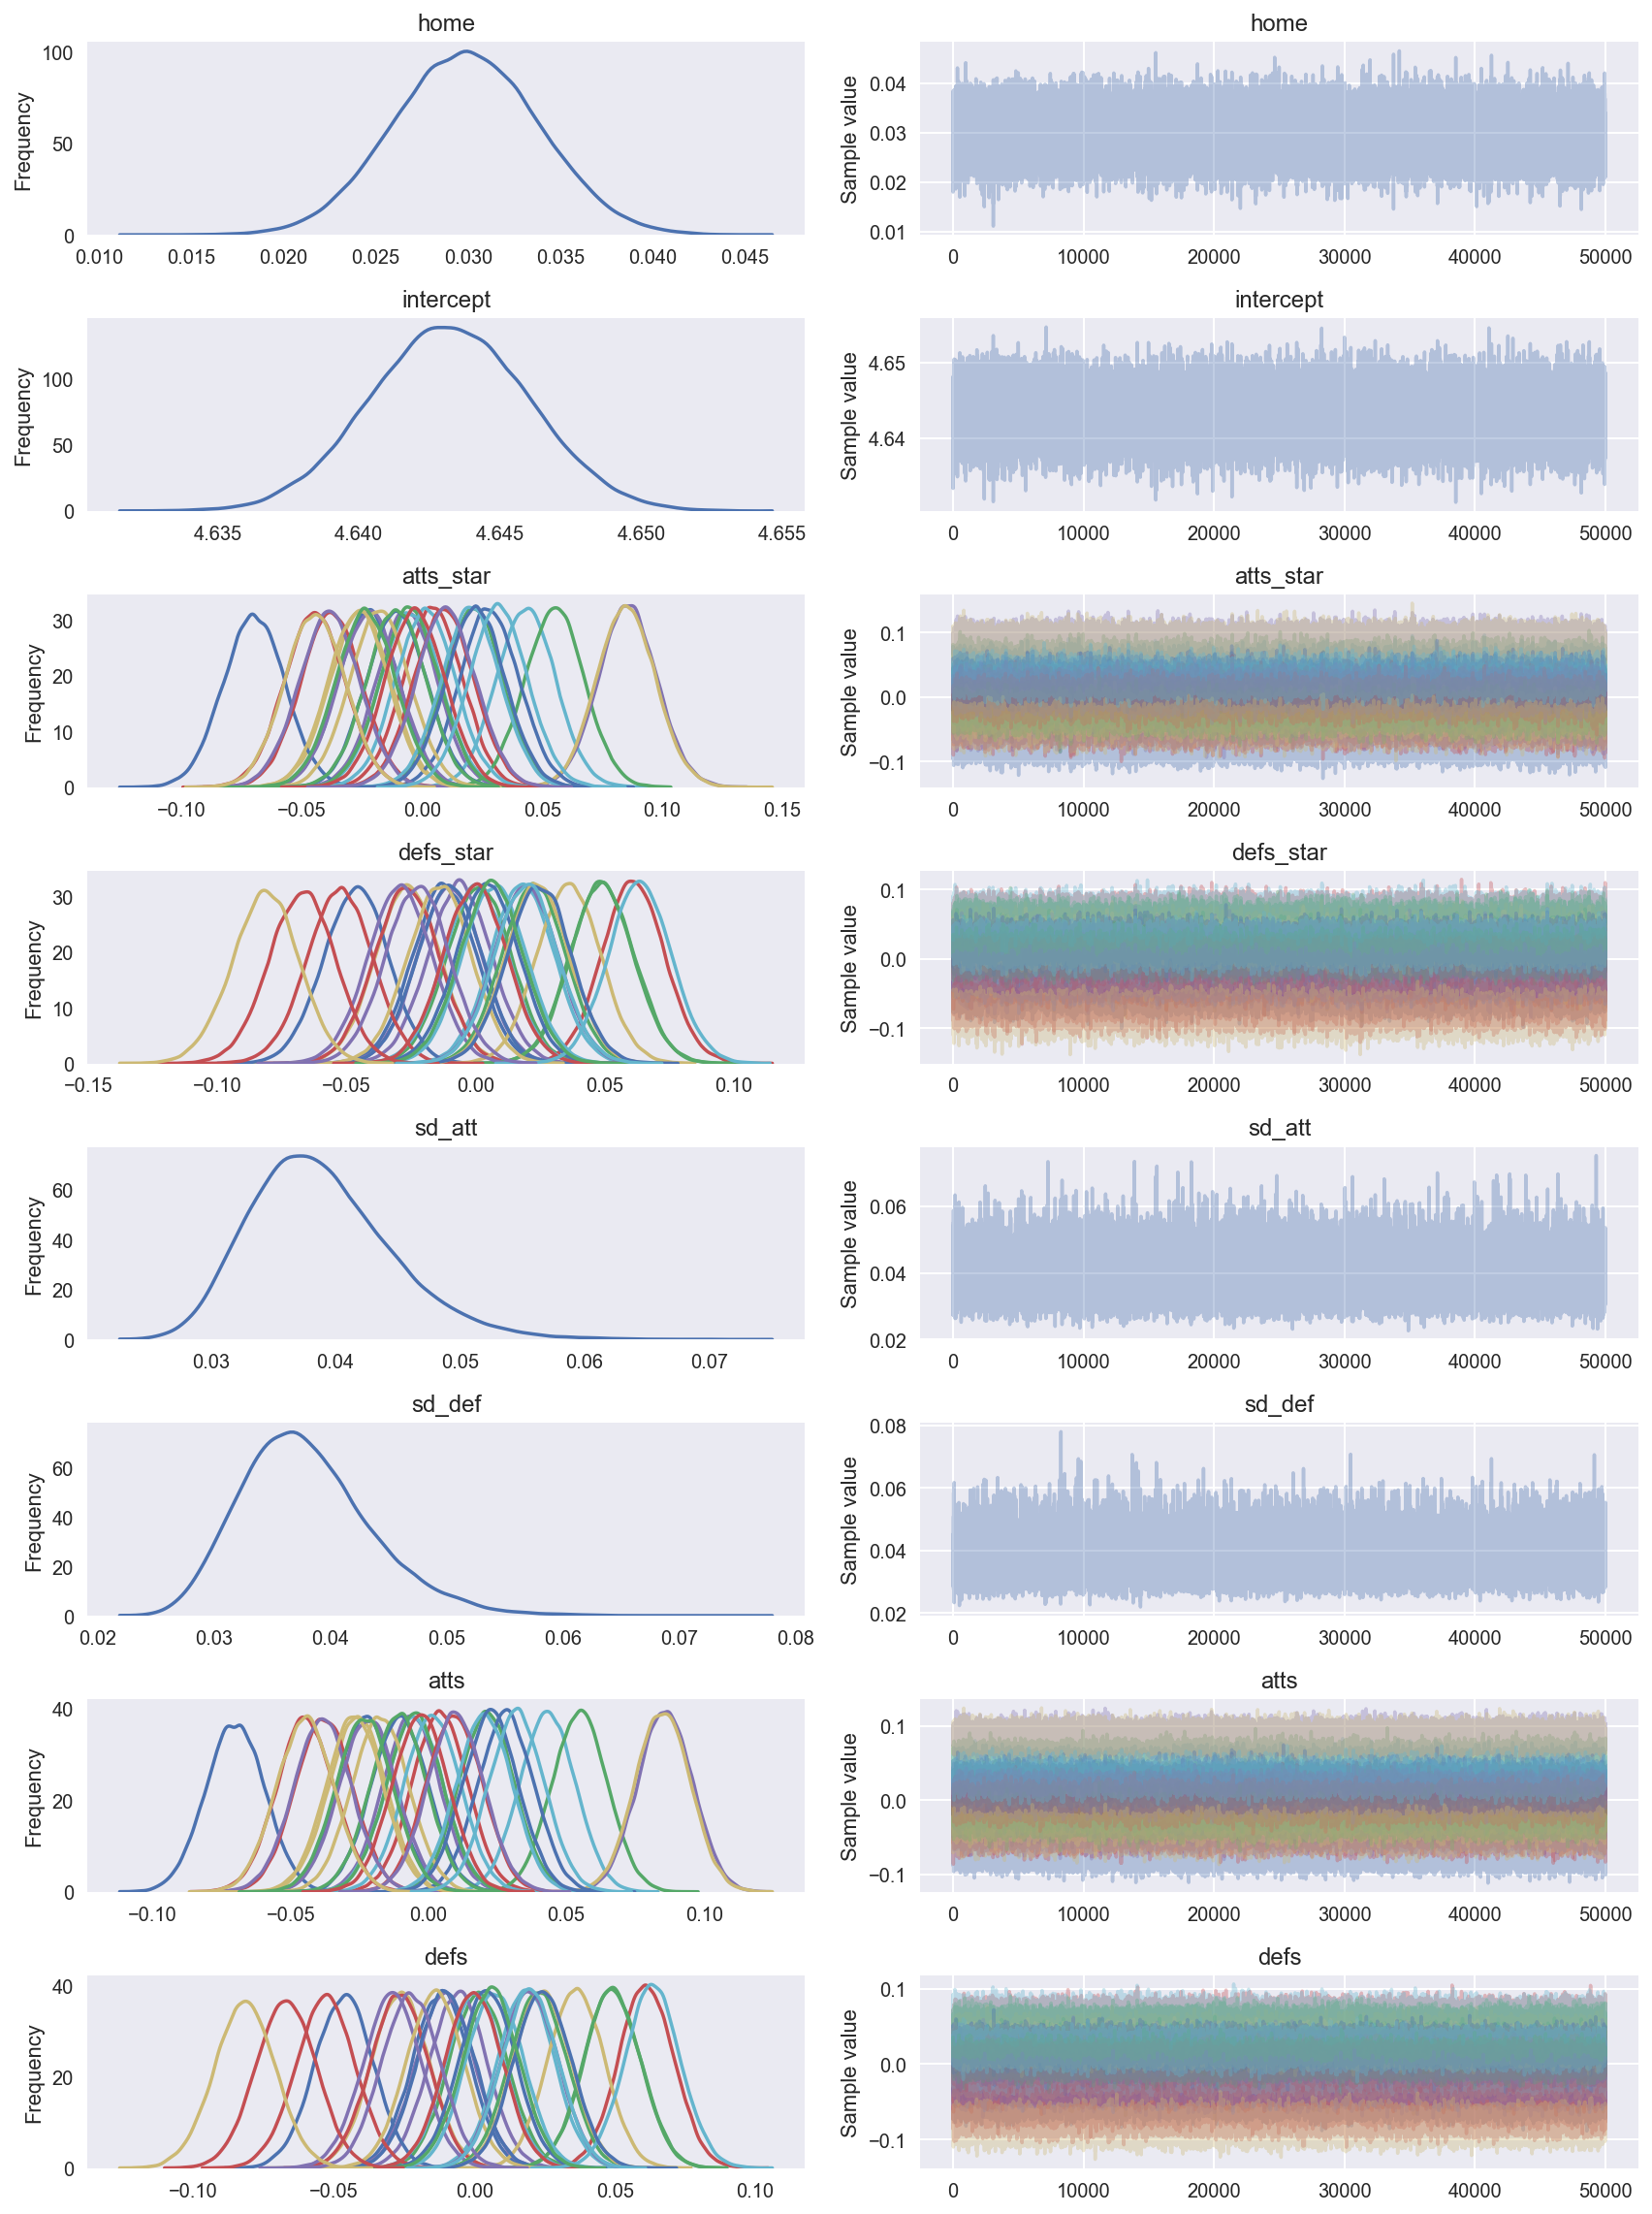

In [12]:
with model:
    trace = pm.sample(50000, tune=1000)
    pm.traceplot(trace)

In [13]:
avg_att = pm.df_summary(trace, varnames=['atts'])['mean']
avg_def = pm.df_summary(trace, varnames=['defs'])['mean']

hpd_low_att = pm.df_summary(trace, varnames=['atts'])['hpd_2.5']
hpd_high_att = pm.df_summary(trace, varnames=['atts'])['hpd_97.5']

hpd_low_def = pm.df_summary(trace, varnames=['defs'])['hpd_2.5']
hpd_high_def  = pm.df_summary(trace, varnames=['defs'])['hpd_97.5']

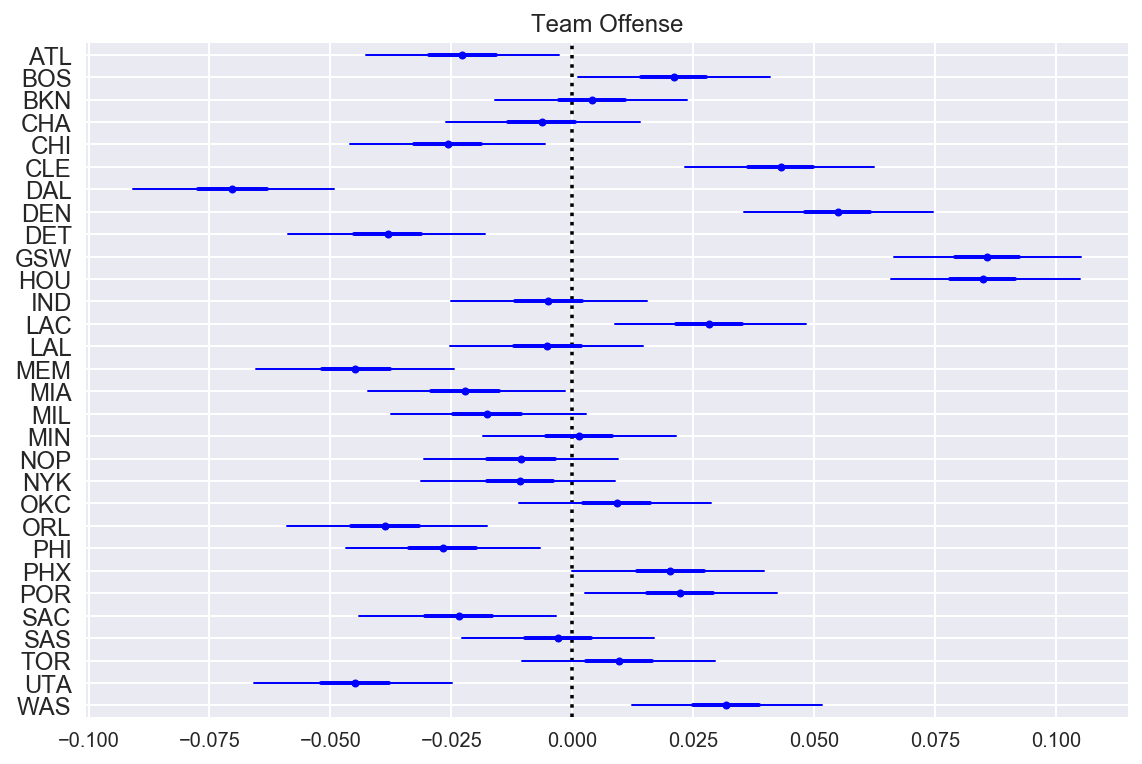

In [14]:
pm.forestplot(trace, varnames=['atts'], ylabels = labels, main="Team Offense")

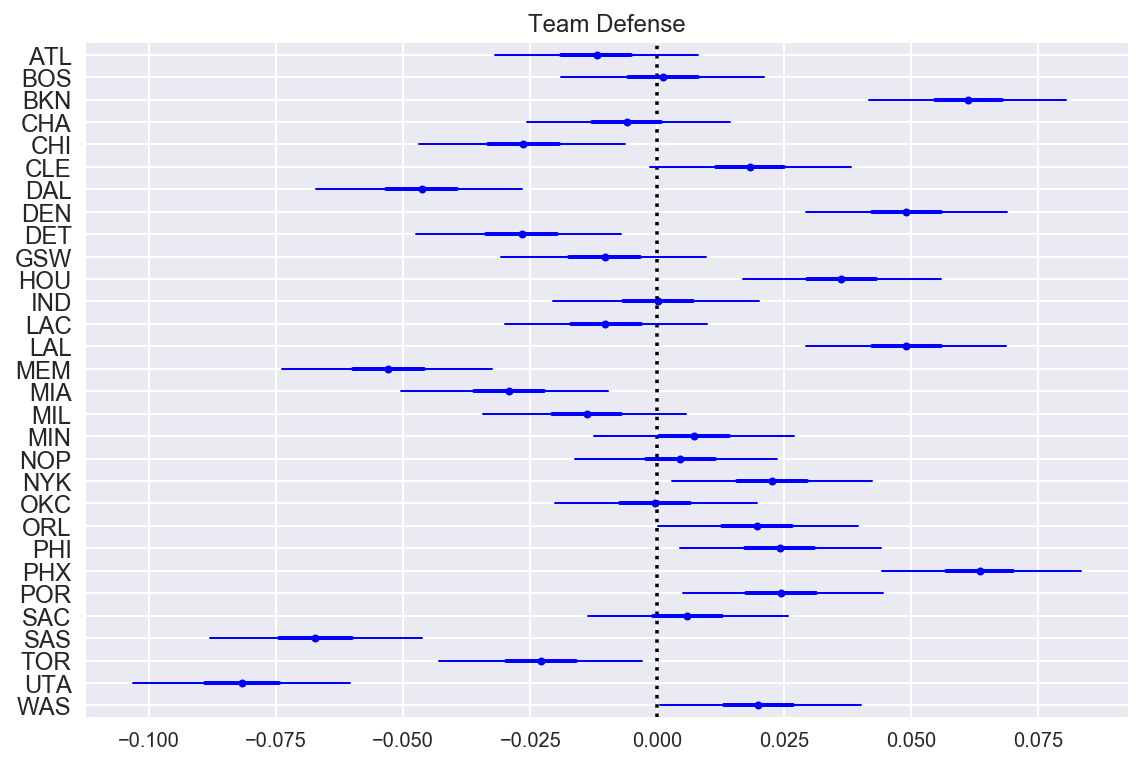

In [15]:
pm.forestplot(trace, varnames=['defs'], ylabels = labels, main="Team Defense")

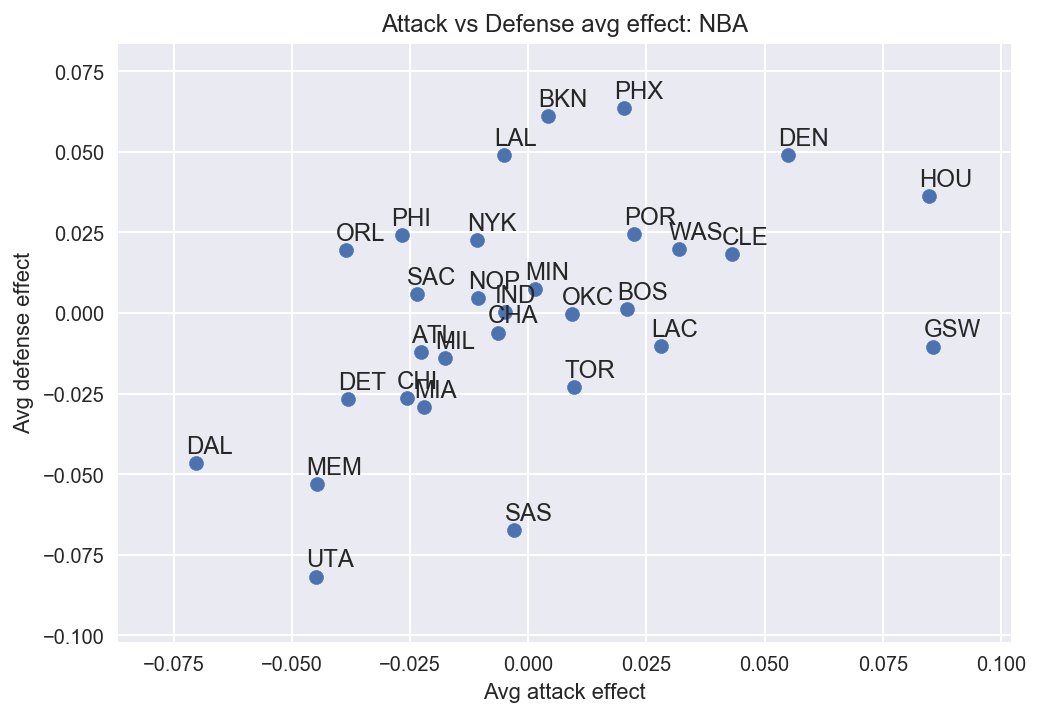

In [16]:
fig, ax = plt.subplots()
ax.scatter(
   x=avg_att, y=avg_def, marker='o', cmap=plt.get_cmap('Spectral'))

for label, x, y in zip(labels, avg_att, avg_def):
    ax.annotate(label, xy=(x, y), xytext = (-5,5), textcoords = 'offset points')
ax.set_title('Attack vs Defense avg effect: NBA')
ax.set_xlabel('Avg attack effect')
ax.set_ylabel('Avg defense effect')

In [17]:
def trace_quantiles(x):
    return pd.DataFrame(pm.quantiles(x, [50]))

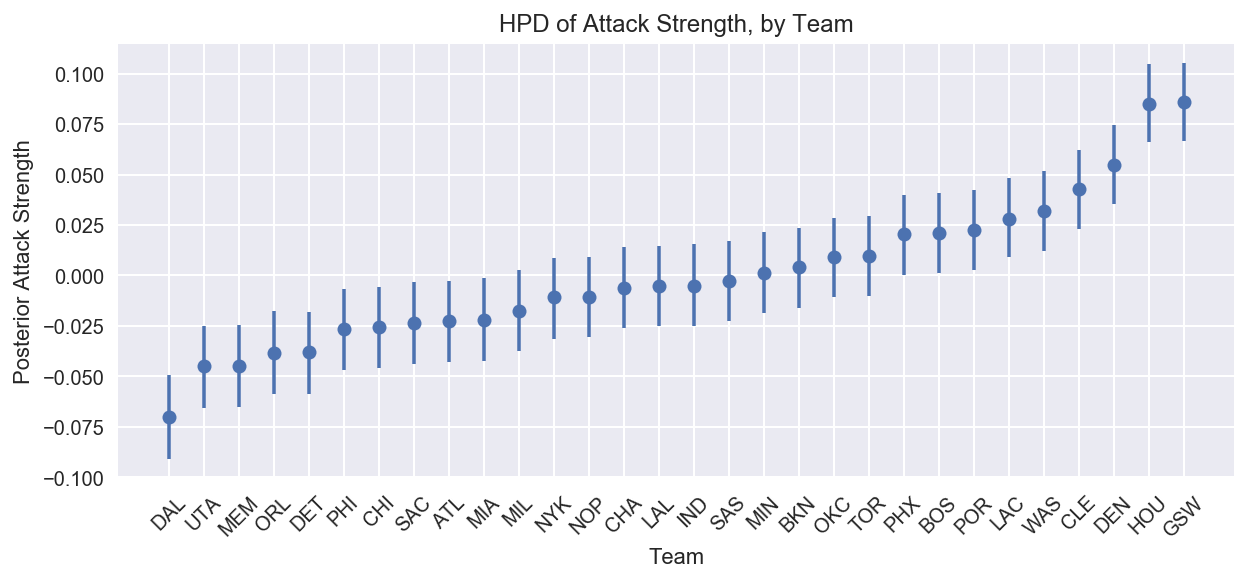

In [18]:
df_hpd_med = pm.df_summary(trace, ['atts'], stat_funcs=[trace_quantiles])
df_hpd_med.columns = ['hpd_med_att']

df_hpd = pd.DataFrame( {'hpd_high_att' : hpd_high_att, 
                        'hpd_low_att' : hpd_low_att,
                        'teams' : labels})

df_hpd = df_hpd.join(df_hpd_med)

df_hpd['relative_lower'] = df_hpd.hpd_med_att - df_hpd.hpd_low_att
df_hpd['relative_upper'] = df_hpd.hpd_high_att - df_hpd.hpd_med_att
df_hpd = df_hpd.sort_values(by='hpd_med_att')
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + .5

fig, axs = plt.subplots(figsize=(10,4))
axs.errorbar(df_hpd.x, df_hpd.hpd_med_att, 
             yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T, 
             fmt='o')
axs.set_title('HPD of Attack Strength, by Team')
axs.set_xlabel('Team')
axs.set_ylabel('Posterior Attack Strength')
_= axs.set_xticks(df_hpd.index + .5)

_= axs.set_xticklabels(df_hpd['teams'].values, rotation=45)

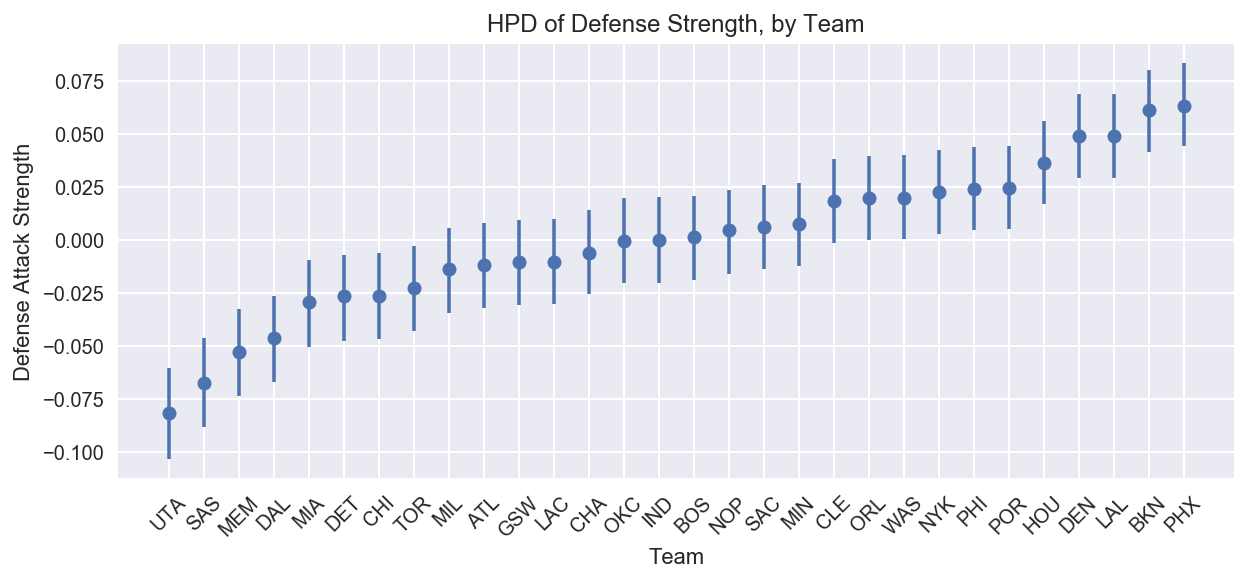

In [19]:
df_hpd_def_med = pm.df_summary(trace, ['defs'], stat_funcs=[trace_quantiles])
df_hpd_def_med.columns = ['hpd_med_def']

df_hpd_def = pd.DataFrame( {'hpd_high_def' : hpd_high_def, 
                        'hpd_low_def' : hpd_low_def,
                        'teams' : labels })

df_hpd_def = df_hpd_def.join(df_hpd_def_med)
df_hpd_def['relative_lower'] = df_hpd_def.hpd_med_def - df_hpd_def.hpd_low_def
df_hpd_def['relative_upper'] = df_hpd_def.hpd_high_def - df_hpd_def.hpd_med_def
df_hpd_def = df_hpd_def.sort_values(by='hpd_med_def')
df_hpd_def = df_hpd_def.reset_index()
df_hpd_def['x'] = df_hpd_def.index + .5

fig, axs = plt.subplots(figsize=(10,4))
axs.errorbar(df_hpd_def.x, df_hpd_def.hpd_med_def, 
             yerr=(df_hpd_def[['relative_lower', 'relative_upper']].values).T, 
             fmt='o')
axs.set_title('HPD of Defense Strength, by Team')
axs.set_xlabel('Team')
axs.set_ylabel('Defense Attack Strength')
_= axs.set_xticks(df_hpd_def.index + .5)
_= axs.set_xticklabels(df_hpd_def['teams'].values, rotation=45)

In [20]:
def match_scores(matches):
    away_array = []
    
    for index, row in matches.iterrows():

        away_temp = np.random.poisson(row['away_theta'])
        
        while away_temp == row['home_points']:
            away_temp = np.random.poisson(row['away_theta'])
        
        away_array.append(away_temp)
    return(away_array)

In [51]:
def simulate_season():
    """
    Simulate a season once, using one random draw from the mcmc chain. 
    """
    num_samples = trace['atts'].shape[0]
    draw = np.random.randint(0, num_samples)
    atts_draw = pd.DataFrame({'att':  trace['atts'][draw]})
    defs_draw = pd.DataFrame({'def':  trace['defs'][draw]})
    home_draw = trace['home'][draw]
    intercept_draw = trace['intercept'][draw]
    season = df_reg_season.copy()
    season = pd.merge(season, atts_draw, left_on='i_home', right_index=True)
    season = pd.merge(season, defs_draw, left_on='i_home', right_index=True)
    season = season.rename(columns = {'att': 'att_home', 'def': 'def_home'})
    season = pd.merge(season, atts_draw, left_on='i_away', right_index=True)
    season = pd.merge(season, defs_draw, left_on='i_away', right_index=True)
    season = season.rename(columns = {'att': 'att_away', 'def': 'def_away'})
    season['home'] = home_draw
    season['intercept'] = intercept_draw
    season['home_theta'] = season.apply(lambda x: math.exp(x['intercept'] + 
                                                           x['home'] + 
                                                           x['att_home'] + 
                                                           x['def_away']), axis=1)
    season['away_theta'] = season.apply(lambda x: math.exp(x['intercept'] + 
                                                           x['att_away'] + 
                                                           x['def_home']), axis=1)
    

    season['home_points'] = season.apply(lambda x: np.random.poisson(x['home_theta']), axis=1)
    season['away_points'] = match_scores(season)
    #season['away_points'] = season.apply(lambda x: np.random.poisson(x['away_theta']), axis=1)
    season['home_outcome'] = season.apply(lambda x: 'win' if x['home_points'] > x['away_points'] else 
                                                    'loss' if x['home_points'] < x['away_points'] else 'draw', axis=1)
    season['away_outcome'] = season.apply(lambda x: 'win' if x['home_points'] < x['away_points'] else 
                                                    'loss' if x['home_points'] > x['away_points'] else 'draw', axis=1)
    season['home_win'] = season.apply(lambda x: 1 if x['home_outcome'] == 'win' else 0, axis = 1)
    season['home_loss'] = season.apply(lambda x: 1 if x['home_outcome'] == 'loss' else 0, axis = 1)
    season['home_draw'] = season.apply(lambda x: 1 if x['home_outcome'] == 'draw' else 0, axis = 1)
    season['away_win'] = season.apply(lambda x: 1 if x['away_outcome'] == 'win' else 0, axis = 1)
    season['away_loss'] = season.apply(lambda x: 1 if x['away_outcome'] == 'loss' else 0, axis = 1)
    season['away_draw'] = season.apply(lambda x: 1 if x['away_outcome'] == 'draw' else 0, axis = 1)
    return season

def create_season_table(season):
    """
    Using a season dataframe output by simulate_season(), create a summary dataframe with wins, losses, goals for, etc.
    
    """
    g = season.groupby('i_home')    
    home = pd.DataFrame({'home_points': g.home_points.sum(),
                         'home_points_against': g.away_points.sum(),
                         'home_wins': g.home_win.sum(),
                         'home_draws': g.home_draw.sum(),
                         'home_losses': g.home_loss.sum()
                         })
    g = season.groupby('i_away')    
    away = pd.DataFrame({'away_goals': g.away_points.sum(),
                         'away_goals_against': g.home_points.sum(),
                         'away_wins': g.away_win.sum(),
                         'away_draws': g.away_draw.sum(),
                         'away_losses': g.away_loss.sum()
                         })
    df = home.join(away)
    df['wins'] = df.home_wins + df.away_wins
    df['draws'] = df.home_draws + df.away_draws
    df['losses'] = df.home_losses + df.away_losses
    df['per_win'] = df.wins / (df.wins + df.losses)
    df = pd.merge(teams, df, left_on='i_number', right_index=True)
    df = df.sort_values(by='per_win', ascending=False)
    df = df.reset_index()
    return df

def simulate_seasons(n=100):
    dfs = []
    for i in range(n):
        if (i % 200) == 0:
            print(i)
        s = simulate_season()
        t = create_season_table(s)
        t['iteration'] = i
        dfs.append(t)
    return pd.concat(dfs, ignore_index=True)

In [57]:
simuls = simulate_seasons(500)

0
200
400


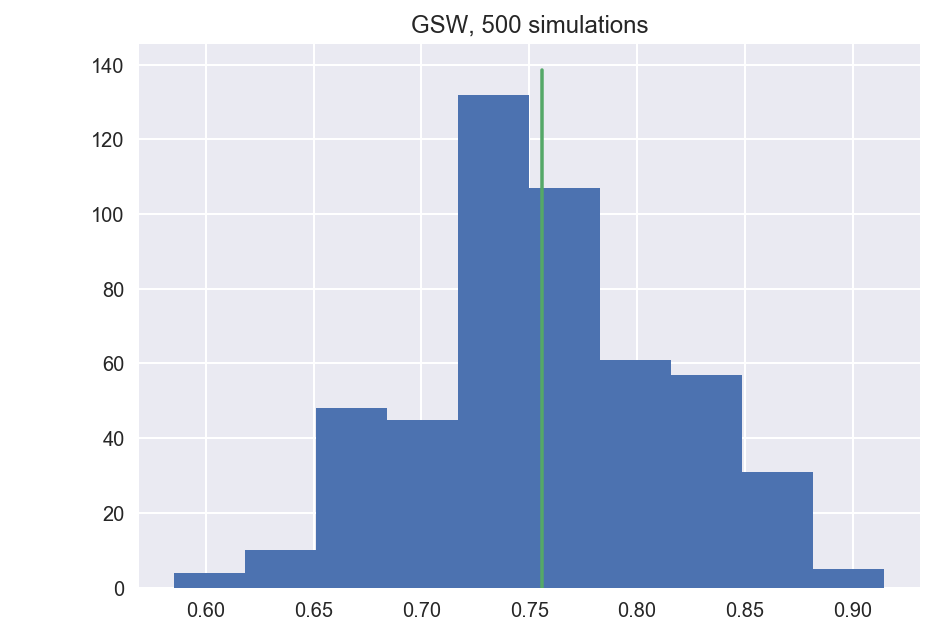

In [58]:
ax = simuls.per_win[simuls.short_name  == 'GSW'].hist(figsize=(7,5))
median = simuls.per_win[simuls.short_name  == 'GSW'].median()
ax.set_title('GSW, 500 simulations')
ax.plot([median, median], ax.get_ylim())
plt.annotate('Median: %s' % median, xy=(median + 1, ax.get_ylim()[1]-10))

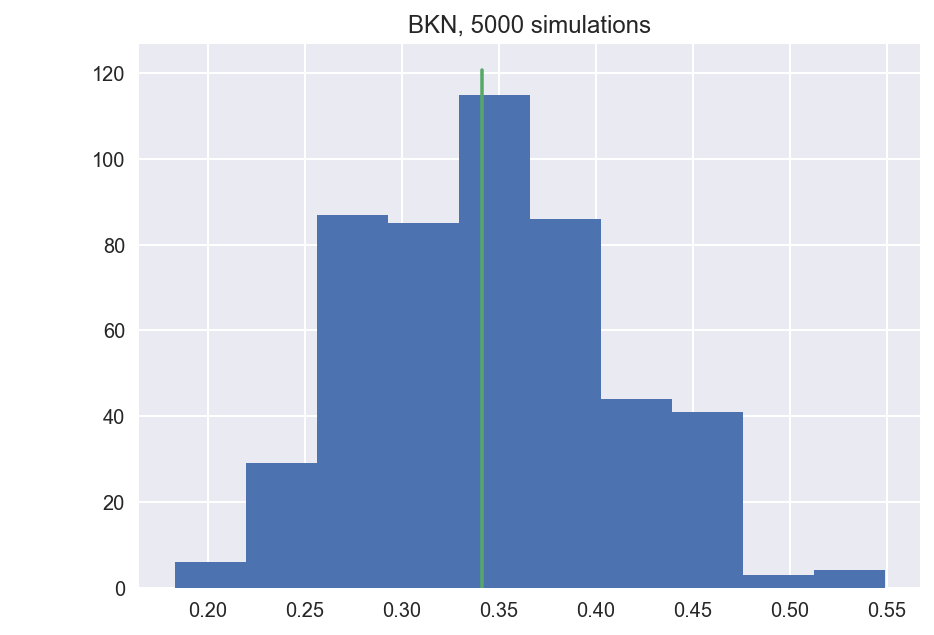

In [59]:
ax = simuls.per_win[simuls.short_name  == 'BKN'].hist(figsize=(7,5))
median = simuls.per_win[simuls.short_name  == 'BKN'].median()
ax.set_title('BKN, 5000 simulations')
ax.plot([median, median], ax.get_ylim())
plt.annotate('Median: %s' % median, xy=(median + 1, ax.get_ylim()[1]-10))

In [94]:
def simulate_playoff_series(seed1, seed2):
    """
    Simulate a playoff series, using one random draw from the mcmc chain. 
    """

    num_samples = trace['atts'].shape[0]
    draw = np.random.randint(0, num_samples)
    atts_draw = pd.DataFrame({'att':  trace['atts'][draw]})
    defs_draw = pd.DataFrame({'def':  trace['defs'][draw]})
    home_draw = trace['home'][draw]
    intercept_draw = trace['intercept'][draw]
    
    if seed1[1] > seed2[1]:
        low_seed = seed2[1]
        low_seed_name = seed2[0]
        i_low_seed = teams[teams['short_name'] == low_seed_name]['i_number'].iloc[0]
        high_seed = seed1[1]
        high_seed_name = seed1[0]
        i_high_seed = teams[teams['short_name'] == high_seed_name]['i_number'].iloc[0]
    else:
        low_seed = seed1[1]
        low_seed_name = seed1[0]
        i_low_seed = teams[teams['short_name'] == low_seed_name]['i_number'].iloc[0]
        high_seed = seed2[1]
        high_seed_name = seed2[0]
        i_high_seed = teams[teams['short_name'] == high_seed_name]['i_number'].iloc[0]

    df_PO = pd.DataFrame(columns=['home_team','home_team_name', 'away_team', 'away_team_name','i_home', 'i_away', 'game'], index=[1,2,3,4,5,6,7])
    df_PO.loc[1] = pd.Series({'home_team': low_seed, 'home_team_name': low_seed_name, 'away_team':high_seed, 'away_team_name': high_seed_name, 'i_home':i_low_seed, 'i_away':i_high_seed, 'game':1})
    df_PO.loc[2] = pd.Series({'home_team': low_seed, 'home_team_name': low_seed_name, 'away_team':high_seed,'away_team_name': high_seed_name, 'i_home':i_low_seed, 'i_away':i_high_seed, 'game':2})
    df_PO.loc[3] = pd.Series({'home_team': high_seed, 'home_team_name': high_seed_name, 'away_team': low_seed,'away_team_name': low_seed_name, 'i_home':i_high_seed, 'i_away':i_low_seed, 'game':3})
    df_PO.loc[4] = pd.Series({'home_team': high_seed, 'home_team_name':high_seed_name, 'away_team':low_seed,'away_team_name': low_seed_name, 'i_home':i_high_seed, 'i_away':i_low_seed, 'game':4})
    df_PO.loc[5] = pd.Series({'home_team': low_seed, 'home_team_name':low_seed_name, 'away_team':high_seed,'away_team_name': high_seed_name, 'i_home':i_low_seed, 'i_away':i_high_seed, 'game':5})
    df_PO.loc[6] = pd.Series({'home_team': high_seed, 'home_team_name':high_seed_name, 'away_team':low_seed,'away_team_name': low_seed_name, 'i_home':i_low_seed, 'i_away':i_low_seed, 'game':6})
    df_PO.loc[7] = pd.Series({'home_team': low_seed, 'home_team_name':low_seed_name, 'away_team':high_seed,'away_team_name': high_seed_name, 'i_home':i_low_seed, 'i_away':i_high_seed, 'game':7})

    df_PO = pd.merge(df_PO, atts_draw, left_on='i_home', right_index=True)
    df_PO = pd.merge(df_PO, defs_draw, left_on='i_home', right_index=True)
    df_PO = df_PO.rename(columns = {'att': 'att_home', 'def': 'def_home'})
    df_PO = pd.merge(df_PO, atts_draw, left_on='i_away', right_index=True)
    df_PO = pd.merge(df_PO, defs_draw, left_on='i_away', right_index=True)
    df_PO = df_PO.rename(columns = {'att': 'att_away', 'def': 'def_away'})

    df_PO = df_PO.sort_values(by= 'game')
    df_PO['home'] = home_draw
    df_PO['intercept'] = intercept_draw
    df_PO['home_theta'] = df_PO.apply(lambda x: math.exp(x['intercept'] + 
                                                           x['home'] + 
                                                           x['att_home'] + 
                                                           x['def_away']), axis=1)
    df_PO['away_theta'] = df_PO.apply(lambda x: math.exp(x['intercept'] + 
                                                           x['att_away'] + 
                                                           x['def_home']), axis=1)
    df_PO['home_points'] = df_PO.apply(lambda x: np.random.poisson(x['home_theta']), axis=1)


    df_PO['away_points'] = match_scores(df_PO)
    df_PO['home_outcome'] = df_PO.apply(lambda x: 'win' if x['home_points'] > x['away_points'] else 
                                                    'loss' if x['home_points'] < x['away_points'] else 'draw', axis=1)
    df_PO['away_outcome'] = df_PO.apply(lambda x: 'win' if x['home_points'] < x['away_points'] else 
                                                    'loss' if x['home_points'] > x['away_points'] else 'draw', axis=1)
    df_PO['high_seed_win'] = df_PO.apply(lambda x: 1 if x['home_team'] == high_seed and x['home_outcome'] == 'win' or 
                                                    x['away_team'] == high_seed and x['home_outcome'] == 'loss' else 0, axis=1)
    df_PO['low_seed_win'] = df_PO.apply(lambda x: 1 if x['home_team'] == low_seed and x['home_outcome'] == 'win' or 
                                                    x['away_team'] == low_seed and x['home_outcome'] == 'loss' else 0, axis=1)

    df_PO['high_seed_cum_win'] = df_PO['high_seed_win'].cumsum()
    df_PO['low_seed_cum_win'] = df_PO['low_seed_win'].cumsum()
    df_PO['max_cum_win'] = df_PO[['high_seed_cum_win', 'low_seed_cum_win']].max(axis=1)
    df_PO['low_seed'] = low_seed
    df_PO['high_seed'] = high_seed
    df_PO['low_seed_name'] = low_seed_name
    df_PO['high_seed_name'] = high_seed_name

    for l in range(7):
        if df_PO['max_cum_win'].iloc[l] == 4:
            return(df_PO.head(l+1))

In [163]:
def get_playoff_series_result(seed1, seed2, po_round):
    """
    Clean the Playoff series results 
    """
            
    results_series = simulate_playoff_series(seed1, seed2)
    last_game =results_series.tail(1)

    if last_game['low_seed_cum_win'].iloc[0] >  last_game['high_seed_cum_win'].iloc[0]:
        seed_winner = last_game['low_seed'].iloc[0]
        seed_loser = last_game['high_seed'].iloc[0]
        team_winner = last_game['low_seed_name'].iloc[0]
        team_looser = last_game['high_seed_name'].iloc[0]
        teams_wins = last_game['low_seed_cum_win'].iloc[0]
        teams_losses = last_game['high_seed_cum_win'].iloc[0]
    else :
        seed_winner = last_game['high_seed'].iloc[0]
        seed_loser = last_game['low_seed'].iloc[0]
        team_winner = last_game['high_seed_name'].iloc[0]
        team_looser = last_game['low_seed_name'].iloc[0]
        teams_wins = last_game['high_seed_cum_win'].iloc[0]
        teams_losses = last_game['low_seed_cum_win'].iloc[0]
        
    return([team_winner, seed_winner, teams_wins, teams_losses, po_round+1], [ team_looser, seed_loser, teams_losses, teams_wins, po_round])

In [164]:
get_playoff_series_result(['GSW', 1], ['SAC',2], 1)

(['GSW', 1, 4, 0, 2], ['SAC', 2, 0, 4, 1])

In [165]:
def get_seed_po (conf_standing):
    """
    Get the regular season seeds 
    """
    conf_standing_po = conf_standing.iloc[0:8:,0:1]
    try:
        conf_standing_po = conf_standing_po.rename(columns={'Western Conference':'conference'})
    except:
        pass
    
    try :
        conf_standing_po = conf_standing_po.rename(columns={'Eastern Conference':'conference'})
    except:
        pass

    conf_standing_po['home_long'] = conf_standing_po.apply(lambda x: re.search(r"[a-zA-Z 1-9]*", x['conference']).group(0), axis=1)
    
    conf_standing_po['seed'] = [1,2,3,4,5,6,7,8]
    conf_standing_po = pd.merge(conf_standing_po, teams, left_on='home_long', right_on = 'long_name', how='left')
    conf_standing_po.drop(['conference', 'home_long'], axis=1, inplace = True)
    return(conf_standing_po)

In [182]:
def simulate_po_conference(conf_standing):
    conf_seeds = get_seed_po(conf_standing)

    seeds = []

    for j in zip(conf_seeds['short_name'], conf_seeds['seed']):
        seeds.append(j) 

    serie_QF_1 = get_playoff_series_result(seeds[0], seeds[7],  1)
    serie_QF_2 = get_playoff_series_result(seeds[1], seeds[6],  1)
    serie_QF_3 = get_playoff_series_result(seeds[2], seeds[5],  1)
    serie_QF_4 = get_playoff_series_result(seeds[3], seeds[4],  1)


    serie_SF_1 = get_playoff_series_result(serie_QF_1[0][0:2], serie_QF_4[0][0:2], 2)
    serie_SF_2 = get_playoff_series_result(serie_QF_2[0][0:2], serie_QF_3[0][0:2], 2)
    serie_F_1 = get_playoff_series_result(serie_SF_1[0][0:2], serie_SF_2[0][0:2], 3)

    po_results = pd.DataFrame([serie_QF_1[0], serie_QF_1[1]], columns=('short_name', 'seed', 'wins', 'losses', 'po_round'))
    po_results = po_results.append(pd.DataFrame([serie_QF_2[0], serie_QF_2[1]], columns=('short_name', 'seed', 'wins', 'losses', 'po_round')))
    po_results = po_results.append(pd.DataFrame([serie_QF_3[0], serie_QF_3[1]], columns=('short_name', 'seed', 'wins', 'losses', 'po_round')))
    po_results = po_results.append(pd.DataFrame([serie_QF_4[0], serie_QF_4[1]], columns=('short_name', 'seed', 'wins', 'losses', 'po_round')))
    po_results = po_results.append(pd.DataFrame([serie_SF_1[0], serie_SF_1[1]], columns=('short_name', 'seed', 'wins', 'losses', 'po_round')))
    po_results = po_results.append(pd.DataFrame([serie_SF_2[0], serie_SF_2[1]], columns=('short_name', 'seed', 'wins', 'losses', 'po_round')))
    po_results = po_results.append(pd.DataFrame([serie_F_1[0], serie_F_1[1]], columns=('short_name', 'seed', 'wins', 'losses', 'po_round')))


    po_results_group = po_results.groupby('short_name')   
    po_results_sum = pd.DataFrame({'seed': po_results_group.seed.mean(),
                         'wins': po_results_group.wins.sum(),
                         'losses': po_results_group.losses.sum(),
                         'po_round': po_results_group.po_round.max()
                         })
    po_results_sum = po_results_sum.sort_values(by='po_round', ascending=False)
    return(po_results_sum)

In [193]:
print(simulate_po_conference(west_standing))
print(simulate_po_conference(east_standing))

            losses  po_round  seed  wins
short_name                              
GSW              5         4     1    12
SAS              7         3     2     9
LAC              6         2     4     6
OKC              6         2     6     4
HOU              4         1     3     2
MEM              4         1     7     3
POR              4         1     8     2
UTA              4         1     5     2
            losses  po_round  seed  wins
short_name                              
BOS              7         4     1    12
TOR              7         3     3    11
CLE              7         2     2     7
WAS              6         2     4     7
ATL              4         1     5     2
CHI              4         1     8     1
IND              4         1     7     3
MIL              4         1     6     0


In [294]:
def simulate_playoffs():
    simulate_po_all = pd.concat([simulate_po_conference(west_standing),simulate_po_conference(east_standing)])
    simulate_po_all.sort_values(by='po_round', ascending=False, inplace = True)

    finalist_1 = (simulate_po_all.index[0], expanded_standing[expanded_standing['short_name'] == simulate_po_all.index[0]].iloc[0].name)
    finalist_2 = (simulate_po_all.index[1], expanded_standing[expanded_standing['short_name'] == simulate_po_all.index[1]].iloc[0].name)

    finals = get_playoff_series_result(finalist_1, finalist_2, 4)

    final_results = pd.DataFrame([finals[0], finals[1]], columns=('team', 'seed', 'wins', 'losses', 'po_round'))
    final_results.drop('seed', axis = 1, inplace = True)

    final_results = final_results.groupby('team')

    final_results_sum = pd.DataFrame({'wins': final_results.wins.sum(),
                             'losses': final_results.losses.sum(),
                             'po_round': final_results.po_round.max()
                             })

    po_all_results = pd.concat([simulate_po_all, final_results_sum])



    po_all_results.reset_index(drop=False, inplace = True)
    po_all_results.rename(columns={'index': 'short_name'}, inplace=True)

    po_all_results_sum = po_all_results.groupby('short_name')

    po_all_results_sum = pd.DataFrame({'wins': po_all_results_sum.wins.sum(),
                             'losses': po_all_results_sum.losses.sum(),
                             'po_round': po_all_results_sum.po_round.max(),
                             'seed' :  po_all_results_sum.seed.mean()
                             })

    po_all_results_sum = po_all_results_sum.sort_values(by=['po_round', 'wins'], ascending=False)
    po_all_results_sum.reset_index(drop=False, inplace = True)
    po_all_results_sum.rename(columns={'index': 'short_name'}, inplace=True)
    return(po_all_results_sum)



In [319]:
simulate_playoffs()

,short_name,losses,po_round,seed,wins
0,GSW,4,5,1.0,16
1,TOR,7,4,3.0,13
2,WAS,6,3,4.0,9
3,SAS,7,3,2.0,8
4,LAC,7,2,4.0,7
5,OKC,6,2,6.0,6
6,CHI,6,2,8.0,5
7,IND,4,2,7.0,5
8,UTA,4,1,5.0,3
9,BOS,4,1,1.0,2


In [296]:
def simulate_playoffs_seasons(n=100):
    dfs = []
    for i in range(n):
        if (i % 10) == 0:
            print(i)
        s = simulate_playoffs()
        s['iteration'] = i
        dfs.append(s)
    return pd.concat(dfs, ignore_index=True)

In [320]:
playoffs_test = simulate_playoffs_seasons(300)
print(playoffs_test.head())

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
  short_name  losses  po_round  seed  wins  iteration
0        GSW      11         5   1.0    16          0
1        TOR       9         4   3.0    15          0
2        SAS       5         3   2.0    10          0
3        WAS       9         3   4.0     9          0
4        UTA       7         2   5.0     7          0


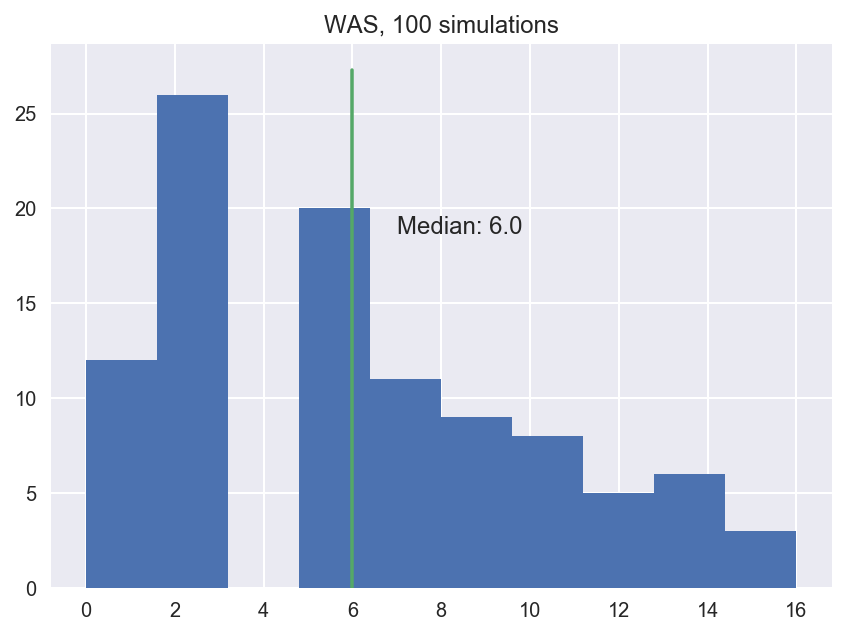

In [308]:
ax = playoffs_test.wins[playoffs_test.short_name  == 'WAS'].hist(figsize=(7,5))
median = playoffs_test.wins[playoffs_test.short_name  == 'WAS'].median()
ax.set_title('WAS, 100 simulations')
ax.plot([median, median], ax.get_ylim())
plt.annotate('Median: %s' % median, xy=(median + 1, ax.get_ylim()[1]-10))

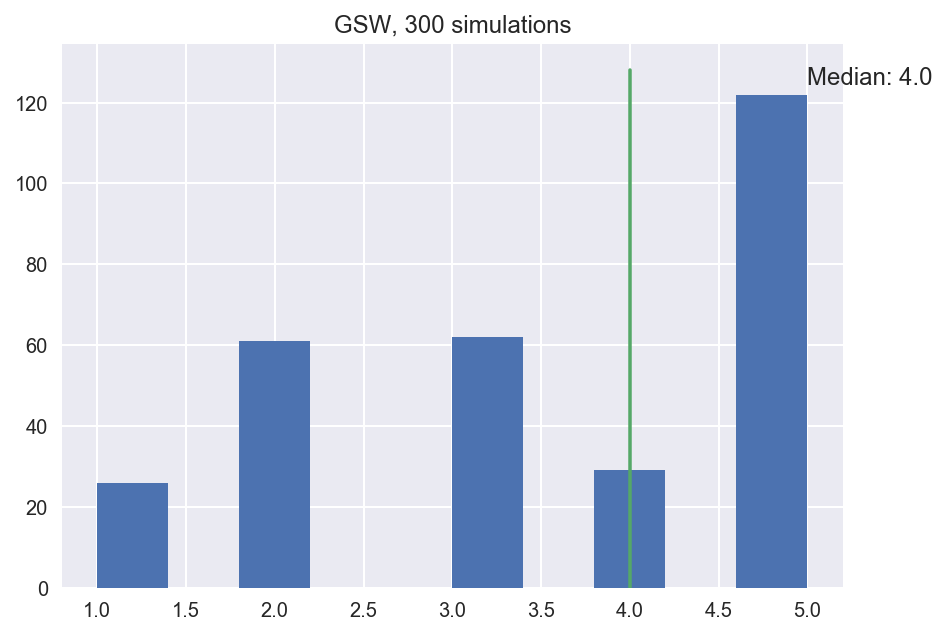

In [321]:
ax = playoffs_test.po_round [playoffs_test.short_name  == 'GSW'].hist(figsize=(7,5))
median = playoffs_test.po_round [playoffs_test.short_name  == 'GSW'].median()
ax.set_title('GSW, 300 simulations')
ax.plot([median, median], ax.get_ylim())
plt.annotate('Median: %s' % median, xy=(median + 1, ax.get_ylim()[1]-10))